# Imports

In [1]:
! pip install transformers datasets evaluate
! pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7509e2412bcd111a6f578e799e87db47f529a350f2f7a792b22429dc03f20fd7
  St

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import evaluate
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,DataCollatorForTokenClassification,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFRobertaForTokenClassification,TFAutoModelForTokenClassification)
from datasets import Dataset

In [3]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-23 15:15:39--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-23 15:15:39 (98.7 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [4]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d namanj27/ner-dataset
! unzip "/content/ner-dataset.zip" -d "/content/dataset/"

  0% 0.00/3.17M [00:00<?, ?B/s]
100% 3.17M/3.17M [00:00<00:00, 120MB/s]
Archive:  /content/ner-dataset.zip
  inflating: /content/dataset/ner_datasetreference.csv  


In [6]:
data_path = "/content/dataset/ner_datasetreference.csv"
df = pd.read_csv(data_path, encoding='unicode_escape')
df.fillna(method='ffill', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [8]:
df.describe()

,Sentence #,Word,POS,Tag
count,1048575,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 22480,the,NN,O
freq,104,52573,145807,887908


In [9]:
print("Number of unique words in the dataset: {}".format(df['Word'].nunique()))
print("Number of unique tags in the dataset: {}".format(df['Tag'].nunique()))

Number of unique words in the dataset: 35178
Number of unique tags in the dataset: 17


In [10]:
df['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [11]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [12]:
aggregate_func = lambda s:[(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                        s['POS'].values.tolist(),
                                                        s['Tag'].values.tolist())]

In [13]:
dataset = df.groupby(['Sentence #']).apply(aggregate_func).reset_index().rename(columns={0:'Sentence_POS_Tag_Pair'})
dataset.head(5)

,Sentence #,Sentence_POS_Tag_Pair
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s..."
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat..."
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O..."
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin..."


In [14]:
dataset['Sentence'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
dataset['POS'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[1] for s in sentence]))
dataset['Tag'] = dataset['Sentence_POS_Tag_Pair'].apply(lambda sentence:" ".join([s[2] for s in sentence]))

In [15]:
dataset['Sentences_list'] = dataset['Sentence'].apply(lambda x:x.split())
dataset['Tag_list'] = dataset['Tag'].apply(lambda x:x.split())

In [16]:
dataset['Sentence_len'] = dataset['Sentences_list'].apply(lambda x: len(x))
dataset['Tag_len'] = dataset['Tag_list'].apply(lambda x:len(x))
dataset['Equal'] = dataset.apply(lambda row: 1 if row['Sentence_len'] == row['Tag_len'] else 0, axis=1)

In [17]:
dataset['Equal'].value_counts()

1    47955
0        4
Name: Equal, dtype: int64

In [18]:
dataset = dataset[dataset['Equal'] != 0]

In [19]:
BATCH_SIZE = 16
NUM_EPOCHS = 2

In [20]:
dataset = Dataset.from_pandas(dataset)

In [21]:
dataset

Dataset({
    features: ['Sentence #', 'Sentence_POS_Tag_Pair', 'Sentence', 'POS', 'Tag', 'Sentences_list', 'Tag_list', 'Sentence_len', 'Tag_len', 'Equal', '__index_level_0__'],
    num_rows: 47955
})

In [22]:
dataset[0]

{'Sentence #': 'Sentence: 1',
 'Sentence_POS_Tag_Pair': [['Thousands', 'NNS', 'O'],
  ['of', 'IN', 'O'],
  ['demonstrators', 'NNS', 'O'],
  ['have', 'VBP', 'O'],
  ['marched', 'VBN', 'O'],
  ['through', 'IN', 'O'],
  ['London', 'NNP', 'B-geo'],
  ['to', 'TO', 'O'],
  ['protest', 'VB', 'O'],
  ['the', 'DT', 'O'],
  ['war', 'NN', 'O'],
  ['in', 'IN', 'O'],
  ['Iraq', 'NNP', 'B-geo'],
  ['and', 'CC', 'O'],
  ['demand', 'VB', 'O'],
  ['the', 'DT', 'O'],
  ['withdrawal', 'NN', 'O'],
  ['of', 'IN', 'O'],
  ['British', 'JJ', 'B-gpe'],
  ['troops', 'NNS', 'O'],
  ['from', 'IN', 'O'],
  ['that', 'DT', 'O'],
  ['country', 'NN', 'O'],
  ['.', '.', 'O']],
 'Sentence': 'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'POS': 'NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP CC VB DT NN IN JJ NNS IN DT NN .',
 'Tag': 'O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O',
 'Sentences_list': ['Thous

# Tokenizer

In [23]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id, add_prefix_space=True)

In [24]:
inputs = tokenizer(dataset[20]["Sentences_list"], is_split_into_words=True)
inputs.tokens()

['<s>',
 'ĠDoctors',
 'Ġsay',
 'Ġthe',
 'Ġstroke',
 'Ġhas',
 'Ġnot',
 'Ġcaused',
 'Ġany',
 'Ġpermanent',
 'Ġdamage',
 'Ġ.',
 '</s>']

In [25]:
print(dataset[20]['Sentences_list'])

['Doctors', 'say', 'the', 'stroke', 'has', 'not', 'caused', 'any', 'permanent', 'damage', '.']


In [26]:
print(inputs.word_ids())
print(dataset[20]['Tag_list'])

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [27]:
label_map = {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8,
             'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else label_map[labels[word_id]]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = label_map[labels[word_id]]
            new_labels.append(label)
    return new_labels

In [28]:
labels = dataset[20]["Tag_list"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


In [29]:
def tokenizer_function(dataset):
  output = tokenizer(dataset["Sentences_list"], max_length=104, padding='max_length',
                     is_split_into_words=True,truncation=True)
  output['labels'] = align_labels_with_tokens(dataset["Tag_list"], output.word_ids())
  return output

In [30]:
tokenized_dataset = dataset.map(tokenizer_function, remove_columns=['Sentence #', 'Sentence_POS_Tag_Pair', 'Sentence', 'POS', 'Tag', 'Sentence_len', 'Tag_len', 'Equal', '__index_level_0__'])

Map:   0%|          | 0/47955 [00:00<?, ? examples/s]

In [31]:
tokenized_dataset

Dataset({
    features: ['Sentences_list', 'Tag_list', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 47955
})

In [32]:
tokenized_dataset[20]

{'Sentences_list': ['Doctors',
  'say',
  'the',
  'stroke',
  'has',
  'not',
  'caused',
  'any',
  'permanent',
  'damage',
  '.'],
 'Tag_list': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 'input_ids': [0,
  14404,
  224,
  5,
  8579,
  34,
  45,
  1726,
  143,
  4398,
  1880,
  479,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [33]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [34]:
tf_dataset = tokenized_dataset.to_tf_dataset(columns=["input_ids", "attention_mask"],
                                            label_cols=["labels"],
                                            batch_size=BATCH_SIZE,
                                            collate_fn=data_collator,
                                            shuffle=True)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [35]:
total_samples = len(tf_dataset)

train_samples = int(0.8 * total_samples)
val_samples = total_samples - train_samples

tf_train_dataset = tf_dataset.take(train_samples)
tf_val_dataset = tf_dataset.skip(train_samples)

In [36]:
for i in tf_train_dataset.take(1):
  print(i[0])

{'input_ids': <tf.Tensor: shape=(16, 104), dtype=int64, numpy=
array([[    0,    20,   595, ...,     1,     1,     1],
       [    0,   522,   224, ...,     1,     1,     1],
       [    0,    20,  1211, ...,     1,     1,     1],
       ...,
       [    0,    20,  1404, ...,     1,     1,     1],
       [    0, 11503,     9, ...,     1,     1,     1],
       [    0,    20,  1510, ...,     1,     1,     1]])>, 'attention_mask': <tf.Tensor: shape=(16, 104), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}


# Model

In [44]:
from transformers import TFRobertaForTokenClassification, RobertaTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
num_tags = 17
model_id = "roberta-base"

model = TFRobertaForTokenClassification.from_pretrained(model_id, num_labels=17)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_token_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  13073     
                                                                 
Total params: 124068113 (473.28 MB)
Trainable params: 124068113 (473.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
from tensorflow.keras.utils import plot_model

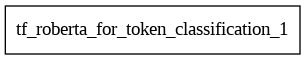

In [46]:
plot_model(model, show_shapes=True)

# Training

In [47]:
batches_per_epoch = len(tokenized_dataset) // BATCH_SIZE
total_train_steps = int(batches_per_epoch*NUM_EPOCHS)

In [48]:
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps,)

In [49]:
model.compile(optimizer=optimizer,
              metrics=['accuracy'])

In [50]:
history = model.fit(tf_train_dataset,
                    validation_data = tf_val_dataset,
                    epochs = NUM_EPOCHS)

Epoch 1/2
2398/2398 [==============================] - 1083s 431ms/step - loss: 0.1888 - accuracy: 0.2225 - val_loss: 0.1200 - val_accuracy: 0.2271
Epoch 2/2
2398/2398 [==============================] - 1042s 435ms/step - loss: 0.1211 - accuracy: 0.2262 - val_loss: 0.1053 - val_accuracy: 0.2275


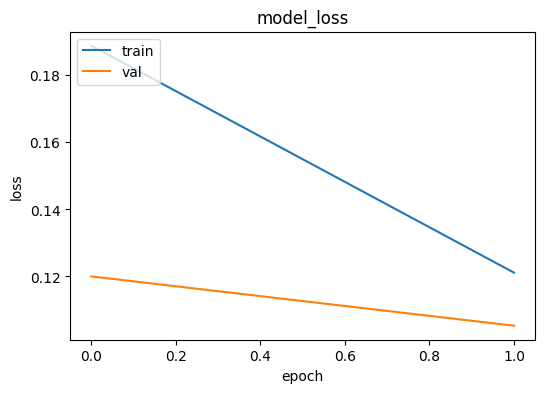

In [51]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Evaluation

In [52]:
metric = evaluate.load("seqeval")

In [53]:
ind_to_label = {v: k for k, v in label_map.items()}
ind_to_label

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [54]:
for inputs, outputs in tf_val_dataset:
  input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
  print(input_ids[0])
  print(attention_mask[0])
  print(outputs[0])
  break

tf.Tensor(
[    0   369  1101  6649     5   232   779   361    30 30421  1295    41
  9111  1748  2187   479     2     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1], shape=(104,), dtype=int64)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(104,), dtype=int64)
tf.Tensor(
[-100    1    4    0    0    0    7   12    0    0    0    0    0

In [55]:
for inputs, outputs in tf_val_dataset:
  input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
  print(input_ids[0])
  print(attention_mask[0])
  print(outputs[0])
  break

In [56]:
all_predictions = []
all_labels = []

for inputs, outputs in tf_val_dataset:
  predictions = model.predict(inputs)["logits"]
  predictions = tf.argmax(predictions, axis=-1).numpy()
  labels = outputs.numpy()
  for prediction, label in zip(predictions, labels):
      for predicted_idx, label_idx in zip(prediction, label):
          if label_idx == -100:
              continue
          all_predictions.append(ind_to_label[predicted_idx])
          all_labels.append(ind_to_label[label_idx])

1/1 [==============================] - 0s 79ms/step


In [57]:
metric.compute(predictions=[all_predictions], references=[all_labels])

{'art': {'precision': 0.6666666666666666,
  'recall': 0.11594202898550725,
  'f1': 0.19753086419753088,
  'number': 138},
 'eve': {'precision': 0.5714285714285714,
  'recall': 0.2711864406779661,
  'f1': 0.367816091954023,
  'number': 59},
 'geo': {'precision': 0.8727243040248184,
  'recall': 0.9008933086128434,
  'f1': 0.8865851130002075,
  'number': 11866},
 'gpe': {'precision': 0.9592592592592593,
  'recall': 0.9262723521320495,
  'f1': 0.942477256822953,
  'number': 3635},
 'nat': {'precision': 0.6842105263157895,
  'recall': 0.14942528735632185,
  'f1': 0.24528301886792456,
  'number': 87},
 'org': {'precision': 0.7580594184576486,
  'recall': 0.7415365589735662,
  'f1': 0.7497069625693521,
  'number': 6469},
 'per': {'precision': 0.8066134125952071,
  'recall': 0.8297343779858589,
  'f1': 0.8180105501130369,
  'number': 5233},
 'tim': {'precision': 0.8842473745624271,
  'recall': 0.8564647377938517,
  'f1': 0.8701343437822942,
  'number': 4424},
 'overall_precision': 0.8493055991

# Model at inference


In [63]:
ind_to_label = {0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
inputs = tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding=True, return_tensors="tf")
logits = model(**inputs).logits
out_str = ""
current_index = 0
for i in range(1, len(inputs.tokens())-1):
  if tf.argmax(logits, axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(logits,axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])
out_str.replace("Ġ","")

print("Output:", out_str)

KeyError: ignored

In [61]:
predicted_labels

array([ 0,  0,  0,  3,  3, 10,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,
        0,  1,  0])

# Saving and Loading Model

In [ ]:
from tensorflow.keras.models import load_model

In [64]:
model.save("Robert_Named_Entity_Recogition")

In [66]:
import tensorflow as tf
from transformers import TFRobertaForTokenClassification

def custom_objects():
    return {"TFRobertaForTokenClassification": TFRobertaForTokenClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = tf.keras.models.load_model("/content/Robert_Named_Entity_Recogition")

ValueError: ignored

In [ ]:
ind_to_label = {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8,
             'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

inputs = tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding=True, return_tensors="tf")
logits = loaded_model(**inputs).logits
out_str = ""
current_index = 0
for i in range(1, len(inputs.tokens())-1):
  if tf.argmax(logits, axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(logits,axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])
out_str.replace("Ġ","")

print("Output:", out_str)

In [ ]:
! cp -av /content/News_Subcategory_Classification /content/drive/MyDrive/News_Subcategory_Classification

# Hugging Face Model

In [ ]:
! pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForTokenClassification

def custom_objects():
    return {"TFRobertaForTokenClassification": TFRobertaForTokenClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Robert_Named_Entity_Recogition")

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = loaded_model, repo_id = "DriveMyScream/Robert_Named_Entity_Recogition")

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForTokenClassification
from huggingface_hub import from_pretrained_keras

def custom_objects():
    return {"TFRobertaForTokenClassification": TFRobertaForTokenClassification}

with tf.keras.utils.custom_object_scope(custom_objects()):
    loaded_model = from_pretrained_keras("DriveMyScream/Robert_Named_Entity_Recogition")

In [ ]:
model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id, add_prefix_space=True)

In [ ]:
ind_to_label = {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8,
             'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

inputs = tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding=True, return_tensors="tf")
logits = loaded_model(**inputs).logits
out_str = ""
current_index = 0
for i in range(1, len(inputs.tokens())-1):
  if tf.argmax(logits, axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(logits,axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])
out_str.replace("Ġ","")

print("Output:", out_str)

# Tensorflow Lite

In [ ]:
import tensorflow as tf
from transformers import TFRobertaForTokenClassification

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Robert_Named_Entity_Recogition.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="Robert_Named_Entity_Recogition.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

model_id = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_id, add_prefix_space=True)

ind_to_label = {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8,
             'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}

input_texts = ["After setting up my account, I feel like I need to change it. How do I go about that? I purchased a product, which I now want to change"]
inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=30, return_tensors="tf")
attention_mask = tf.cast(inputs['attention_mask'], tf.int64)
input_ids = tf.cast(inputs['input_ids'], tf.int64)
token_type_ids = tf.cast(inputs['token_type_ids'], tf.int64)

interpreter.set_tensor(input_details[0]['index'], attention_mask)
interpreter.set_tensor(input_details[1]['index'], input_ids)
interpreter.set_tensor(input_details[2]['index'], token_type_ids)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

out_str = ""
current_index = 0
for i in range(1, len(inputs.tokens())-1):
  if tf.argmax(output_data, axis=-1)[0][i]!=0:
    out_str+=" "+str(inputs.tokens()[i])+"--->"+str(ind_to_label[tf.argmax(output_data, axis=-1).numpy()[0][i]])
  else:
    out_str+=" "+str(inputs.tokens()[i])
out_str.replace("Ġ","")

print("Output:", out_str)